# Function Generation for the Training of λ-Nets

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': -1,
        'fully_grown': True,
        'dt_type': 'SDT', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 23, 
        'num_classes': 2,
        'categorical_indices': [],
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 1, # None; 0; int >= 1
        'exclude_linearly_seperable': False,
        'data_generation_filtering': False,
        'fixed_class_probability': False,
        'balanced_data': True,
        'weighted_data_generation': False,
        'shift_distrib': False,
        
        'function_generation_type': 'random_decision_tree', # 'make_classification_distribution', 'make_classification_distribution_trained', 'distribution', 'distribution_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'distribution_list': ['uniform', 'normal', 'gamma', 'beta', 'poisson'],#['uniform', 'normal', 'gamma', 'beta', 'poisson', 'lognormal', 'exponential', 'f', 'logistic', 'weibull'],#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'], 
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'data_noise': 0, #None or float
        'distrib_param_max': 5,
    }, 
    'computation':{
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}


In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['computation'])

## Imports

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from more_itertools import random_product 
from tqdm import tqdm_notebook as tqdm
import pickle

import numpy as np

import pandas as pd
from joblib import Parallel, delayed

import random 
from random import sample 

import os
import sys

from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler

from sympy import Symbol, sympify

        
import seaborn as sns
        
import random 

import warnings

from time import perf_counter



from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from utilities.DecisionTree_BASIC import SDT
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
from IPython.display import Image

import numpy as np
import torch
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
os.environ['CUDA_VISIBLE_DEVICES'] = ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')



In [5]:
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='data_creation'))
generate_directory_structure()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_function_data)

lNetSize5000_numDatasets10000_var23_class2_random_decision_tree_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_depth3_beta1_decisionSpars-1_SDT_fullyGrown


# Function Generation

In [7]:
if function_generation_type == 'random_decision_tree':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_random_decision_tree)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))
elif function_generation_type == 'random_decision_tree_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_random_decision_tree_trained)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))  
elif function_generation_type == 'make_classification':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets)) 
elif function_generation_type == 'make_classification_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification_decision_tree_trained)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))    
elif function_generation_type == 'make_classification_distribution':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification_distribution)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets)) 
elif function_generation_type == 'make_classification_distribution_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_make_classification_distribution_decision_tree_trained)(config, seed=RANDOM_SEED+i) for i in range(number_of_generated_datasets))    
elif function_generation_type == 'distribution':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #sequential
    result_list = parallel(delayed(generate_data_distribution)(config, 
                                                              seed=RANDOM_SEED+i, 
                                                              max_distributions_per_class=max_distributions_per_class, 
                                                              random_parameters=random_parameters_distribution,
                                                              data_noise=data_noise) for i in range(number_of_generated_datasets))    #, distribution_list = ['uniform']
elif function_generation_type == 'distribution_trained':
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    result_list = parallel(delayed(generate_data_distribution_trained)(config, 
                                                                      seed=RANDOM_SEED+i, 
                                                                      max_distributions_per_class=max_distributions_per_class, 
                                                                      random_parameters=random_parameters_distribution,
                                                                      data_noise=data_noise) for i in range(number_of_generated_datasets))    #, distribution_list = ['uniform']
    
    
function_identifier_list = generate_decision_tree_identifier(config)  
identifier_series_list = [pd.Series(result[0],  index=function_identifier_list) for result in result_list]

function_df = pd.DataFrame(data=np.array([result[0] for result in result_list]), columns=function_identifier_list)

X_data_list = [[identifier_series, pd.DataFrame(result[1], columns=['x' + str(i) for i in range(number_of_variables)])] for identifier_series, result in zip(identifier_series_list, result_list)]
y_data_list = [[identifier_series, pd.DataFrame(result[2], columns=['result'])] for identifier_series, result in zip(identifier_series_list, result_list)]
y_data_raw_list = [[identifier_series, pd.DataFrame(result[3], columns=['result_raw'])] for identifier_series, result in zip(identifier_series_list, result_list)]
try:
    distribution_parameter_list_list =[[identifier_series, result[4]] for identifier_series, result in zip(identifier_series_list, result_list)]
except:
    pass

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:   20.0s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:   21.3s
[Parallel(n_jobs=20)]: Done 472 tasks      | elapsed:   23.1s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   26.5s
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:   30.4s
[Parallel(n_jobs=20)]: Done 1528 tasks      | elapsed:   34.3s
[Parallel(n_jobs=20)]: Done 2008 tasks      | elapsed:   40.3s
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed:   47.4s
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:   54.7s
[Parallel(n_jobs=20)]: Done 3832 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done 4568 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 5368 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done 6232 tasks      | elapsed:  1.5min
[Parallel(n_jobs=20)]: Done 7280 tasks      | elapsed:  1.8min
[Parallel(n_jobs=20)]: Done 9332 tasks      |

In [8]:
function_df.head(20)

,f0v0,f0v1,f0v2,f0v3,f0v4,f0v5,f0v6,f0v7,f0v8,f0v9,f0v10,f0v11,f0v12,f0v13,f0v14,f0v15,f0v16,f0v17,f0v18,f0v19,f0v20,f0v21,f0v22,f1v0,f1v1,f1v2,f1v3,f1v4,f1v5,f1v6,f1v7,f1v8,f1v9,f1v10,f1v11,f1v12,f1v13,f1v14,f1v15,f1v16,f1v17,f1v18,f1v19,f1v20,f1v21,f1v22,f2v0,f2v1,f2v2,f2v3,f2v4,f2v5,f2v6,f2v7,f2v8,f2v9,f2v10,f2v11,f2v12,f2v13,f2v14,f2v15,f2v16,f2v17,f2v18,f2v19,f2v20,f2v21,f2v22,f3v0,f3v1,f3v2,f3v3,f3v4,f3v5,f3v6,f3v7,f3v8,f3v9,f3v10,f3v11,f3v12,f3v13,f3v14,f3v15,f3v16,f3v17,f3v18,f3v19,f3v20,f3v21,f3v22,f4v0,f4v1,f4v2,f4v3,f4v4,f4v5,f4v6,f4v7,f4v8,f4v9,f4v10,f4v11,f4v12,f4v13,f4v14,f4v15,f4v16,f4v17,f4v18,f4v19,f4v20,f4v21,f4v22,f5v0,f5v1,f5v2,f5v3,f5v4,f5v5,f5v6,f5v7,f5v8,f5v9,f5v10,f5v11,f5v12,f5v13,f5v14,f5v15,f5v16,f5v17,f5v18,f5v19,f5v20,f5v21,f5v22,f6v0,f6v1,f6v2,f6v3,f6v4,f6v5,f6v6,f6v7,f6v8,f6v9,f6v10,f6v11,f6v12,f6v13,f6v14,f6v15,f6v16,f6v17,f6v18,f6v19,f6v20,f6v21,f6v22,b0,b1,b2,b3,b4,b5,b6,lp0c0,lp0c1,lp1c0,lp1c1,lp2c0,lp2c1,lp3c0,lp3c1,lp4c0,lp4c1,lp5c0,lp5c1,lp6c0,lp6c1,lp7c0,lp7c1
0,0.159,0.173,-0.049,0.192,-0.046,0.042,-0.102,0.122,0.184,-0.153,0.181,0.039,0.154,0.028,0.101,-0.029,0.161,0.031,-0.097,0.053,-0.096,-0.024,-0.085,0.138,-0.165,-0.096,-0.059,-0.125,0.020,-0.206,0.188,-0.177,0.161,0.035,-0.068,0.129,0.032,0.168,0.023,-0.066,0.056,-0.057,0.088,0.186,0.121,-0.091,0.120,0.037,0.106,-0.127,-0.206,-0.081,-0.160,0.171,0.060,0.086,0.066,-0.004,0.163,-0.148,0.013,-0.142,0.064,-0.072,0.064,-0.043,0.173,-0.124,-0.124,-0.124,0.188,0.069,0.201,-0.172,-0.207,-0.163,-0.140,0.084,0.075,0.173,-0.108,-0.142,0.111,-0.084,0.127,-0.049,0.119,-0.162,-0.105,0.064,0.044,-0.053,0.124,0.142,-0.151,-0.111,0.191,-0.070,-0.074,-0.202,-0.119,0.052,-0.028,-0.151,0.005,-0.142,-0.177,-0.115,-0.182,-0.133,0.208,0.039,0.064,-0.194,-0.137,-0.069,0.033,-0.183,-0.090,-0.125,0.001,-0.078,-0.014,-0.141,-0.143,-0.122,-0.071,-0.165,0.175,-0.041,0.179,0.065,-0.177,0.144,-0.057,-0.080,-0.173,-0.207,0.060,-0.046,0.081,-0.171,0.155,-0.153,-0.036,0.044,0.108,0.168,0.190,-0.165,0.052,-0.090,-0.023,-0.156,0.190,-0.153,0.111,0.073,0.068,-0.113,0.190,0.046,0.027,-0.184,0.088,-0.031,-0.096,0.179,0.079,-0.264,-0.196,0.126,-0.179,0.274,-0.017,-0.333,0.197,0.082,-0.090,0.183,-0.202,0.064,-0.121,-0.126
1,-0.019,-0.127,0.176,-0.064,-0.147,-0.173,0.038,-0.181,0.103,0.052,0.183,-0.153,0.008,0.014,0.016,0.086,-0.030,-0.093,0.142,-0.143,-0.164,0.094,-0.073,0.162,-0.154,0.141,0.026,-0.036,0.151,-0.092,0.035,-0.071,0.074,0.085,0.175,-0.111,0.052,-0.016,0.152,-0.138,-0.072,0.153,0.081,-0.056,0.065,0.077,-0.063,-0.168,-0.161,0.126,-0.021,0.109,-0.158,0.184,0.066,-0.013,-0.088,-0.036,-0.146,-0.177,-0.078,0.125,-0.184,0.156,0.105,-0.150,0.172,0.058,-0.033,0.022,0.049,0.134,0.208,0.057,-0.014,0.021,0.054,-0.073,-0.078,-0.203,0.199,-0.090,-0.017,-0.178,-0.023,0.168,-0.176,0.090,0.196,-0.198,0.018,0.068,0.028,0.006,0.194,0.190,0.012,0.091,-0.061,-0.082,-0.064,0.140,0.182,0.141,0.012,0.067,-0.091,-0.033,-0.163,0.082,-0.127,0.202,0.024,0.106,-0.039,0.051,-0.189,-0.170,-0.105,0.202,0.107,0.114,0.202,0.100,0.087,-0.071,-0.073,0.149,0.178,-0.141,0.084,-0.045,0.203,-0.024,-0.036,-0.017,-0.030,0.185,-0.079,0.085,0.023,0.169,0.128,-0.135,-0.029,-0.007,-0.059,0.152,0.203,-0.173,-0.083,0.199,0.030,-0.060,0.148,-0.025,-0.077,-0.185,0.140,-0.050,-0.134,-0.145,-0.148,0.064,0.070,0.038,-0.130,-0.189,-0.202,-0.140,-0.233,-0.131,0.074,-0.009,0.130,-0.153,-0.133,0.188,-0.323,0.062,0.229,-0.211,0.150,-0.294
2,0.092,0.096,0.137,-0.152,0.053,0.096,-0.088,-0.120,0.202,0.155,0.194,0.118,0.128,-0.183,0.093,-0.069,0.015,0.088,0.124,-0.092,0.165,0.071,0.165,-0.022,-0.009,-0.061,-0.189,0.103,0.118,-0.029,-0.161,0.142,-0.001,-0.059,0.103,-0.172,-0.008,-0.003,0.100,-0.044,-0.196,0.112,0.051,-0.171,-0.030,-0.196,0.087,-0.042,-0.140,0.093,-0.124,0.124,0.144,-0.201,-0.165,0.118,-0.160,0.050,0.102,0.004,-0.100,0.009,0.054,0.162,0.189,0.007,0.012,-0.078,-0.037,-0.051,0.063,0.033,-0.173,0.077,0.049,-0.013,-0.197,0.189,-0.176,0.001,-0.192,0.021,0.026,0.200,0.187,0.074,0.155,0.203,-0.066,-0.113,0.133,

In [9]:
X_data_list[0][0].head(10)

f0v0    0.159
f0v1    0.173
f0v2   -0.049
f0v3    0.192
f0v4   -0.046
f0v5    0.042
f0v6   -0.102
f0v7    0.122
f0v8    0.184
f0v9   -0.153
dtype: float32

In [10]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22
0,0.432,0.291,0.612,0.139,0.292,0.366,0.456,0.785,0.200,0.514,0.593,0.046,0.608,0.171,0.065,0.949,0.966,0.809,0.305,0.097,0.684,0.440,0.122
1,0.495,0.034,0.909,0.259,0.662,0.312,0.520,0.546,0.185,0.970,0.775,0.940,0.895,0.598,0.922,0.088,0.196,0.045,0.325,0.389,0.271,0.829,0.357
2,0.281,0.543,0.141,0.802,0.074,0.987,0.772,0.198,0.005,0.816,0.707,0.729,0.772,0.074,0.359,0.116,0.863,0.623,0.331,0.063,0.311,0.325,0.730
3,0.638,0.887,0.472,0.120,0.713,0.761,0.561,0.771,0.494,0.523,0.428,0.025,0.108,0.031,0.637,0.314,0.509,0.908,0.249,0.410,0.756,0.229,0.077
4,0.290,0.161,0.930,0.808,0.633,0.872,0.804,0.186,0.893,0.539,0.808,0.896,0.318,0.110,0.228,0.427,0.818,0.861,0.007,0.511,0.417,0.222,0.120
5,0.338,0.943,0.323,0.519,0.703,0.364,0.972,0.963,0.252,0.497,0.301,0.285,0.037,0.610,0.503,0.051,0.279,0.908,0.239,0.145,0.489,0.986,0.242
6,0.672,0.762,0.238,0.728,0.368,0.632,0.634,0.536,0.090,0.835,0.321,0.186,0.041,0.591,0.678,0.017,0.512,0.227,0.645,0.174,0.691,0.387,0.937
7,0.137,0.341,0.113,0.925,0.877,0.258,0.660,0.817,0.555,0.530,0.242,0.093,0.898,0.901,0.633,0.339,0.349,0.726,0.897,0.887,0.780,0.642,0.084
8,0.162,0.899,0.607,0.009,0.101,0.664,0.005,0.160,0.549,0.692,0.652,0.224,0.712,0.237,0.325,0.747,0.650,0.849,0.658,0.568,0.094,0.368,0.265
9,0.244,0.973,0.393,0.892,0.631,0.795,0.503,0.577,0.493,0.195,0.723,0.281,0.024,0.646,0.177,0.941,0.954,0.915,0.370,0.015,0.928,0.428,0.967


In [11]:
y_data_list[0][0].head(10)

f0v0    0.159
f0v1    0.173
f0v2   -0.049
f0v3    0.192
f0v4   -0.046
f0v5    0.042
f0v6   -0.102
f0v7    0.122
f0v8    0.184
f0v9   -0.153
dtype: float32

In [12]:
y_data_list[1][1].head(10)

,result
0,1.000
1,0.000
2,1.000
3,1.000
4,0.000
5,0.000
6,0.000
7,0.000
8,1.000
9,1.000


In [13]:
y_data_list[2][1].head(10)

,result
0,1.000
1,0.000
2,1.000
3,1.000
4,1.000
5,1.000
6,1.000
7,0.000
8,1.000
9,1.000


In [14]:
y_data_raw_list[2][1].head(10)

,result_raw
0,0.501
1,0.498
2,0.501
3,0.501
4,0.501
5,0.501
6,0.501
7,0.498
8,0.501
9,0.501


In [15]:
try:
    print(distribution_parameter_list_list[2][1])
except:
    pass

In [16]:
y_data_list[1][0].values

array([-0.01919655, -0.1265719 ,  0.17558402, -0.06414776, -0.14675753,
       -0.17272545,  0.03792599, -0.18101709,  0.1032554 ,  0.05226052,
        0.1831587 , -0.15272206,  0.00796329,  0.01398422,  0.01564965,
        0.08583688, -0.0302187 , -0.09336635,  0.14160816, -0.14334424,
       -0.1638068 ,  0.09430713, -0.07337105,  0.16232558, -0.1535469 ,
        0.14072746,  0.02608185, -0.03593459,  0.15098622, -0.09203628,
        0.03478935, -0.07141633,  0.07393873,  0.0853122 ,  0.17544305,
       -0.11103427,  0.05240021, -0.01567851,  0.15243281, -0.13784786,
       -0.07155314,  0.15277323,  0.08134679, -0.0562445 ,  0.06526068,
        0.07676602, -0.06298786, -0.16823368, -0.1609147 ,  0.12564144,
       -0.02105482,  0.10894272, -0.15846546,  0.18401808,  0.06557251,
       -0.01257638, -0.08803694, -0.0358662 , -0.1459457 , -0.17668542,
       -0.07791547,  0.1253429 , -0.18355773,  0.1560833 ,  0.10537064,
       -0.14991045,  0.17167509,  0.05817908, -0.03325437,  0.02

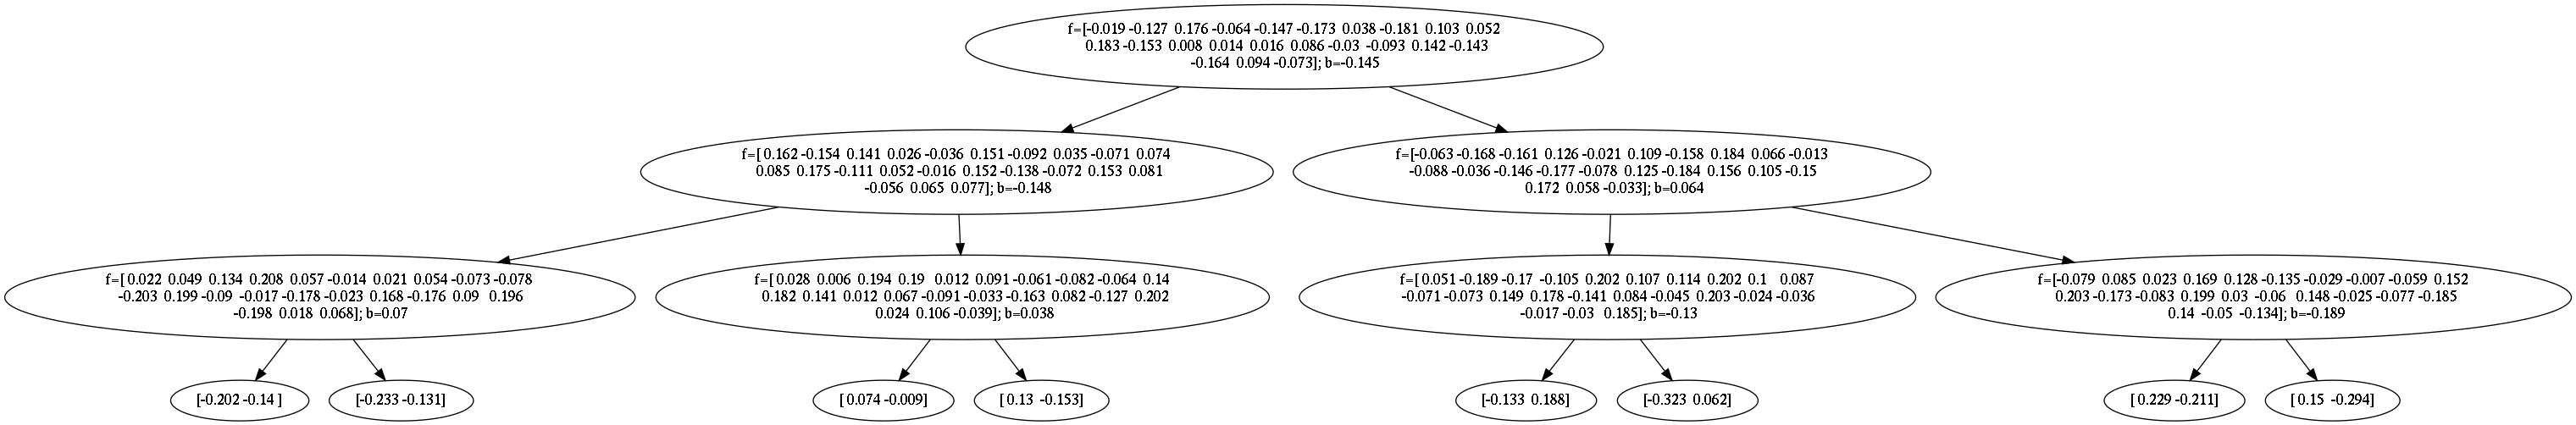

In [17]:
plot_tree_from_parameters(y_data_list[1][0].values, config)

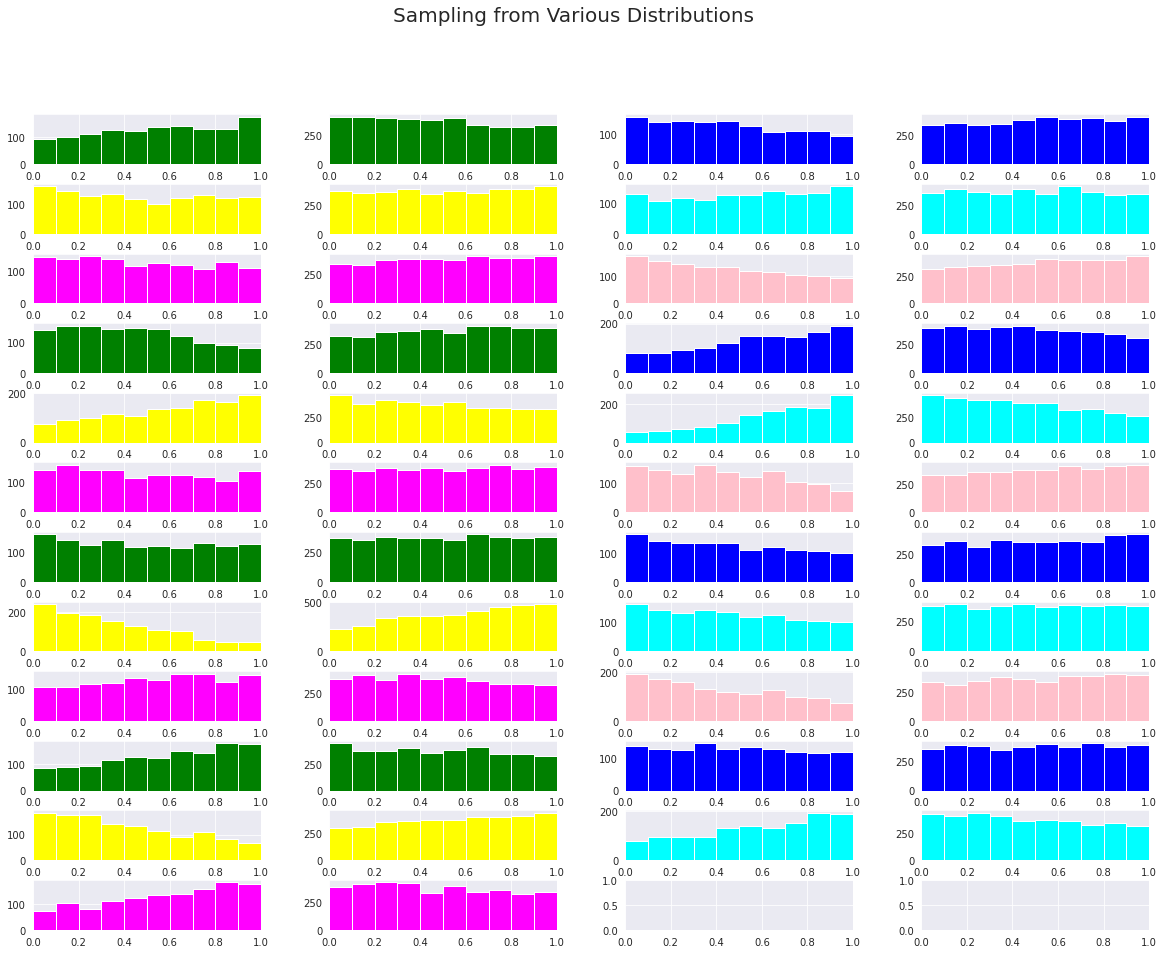

In [18]:
rand_index = 5

colors_list = ['green','blue','yellow','cyan','magenta','pink']

if config['data']['number_of_variables'] > 4:
    fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
else:
    fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))

for axis_1 in ax:
    for axis_2 in axis_1:
        axis_2.set_xlim([0, 1])                          

plot_index = 0

for i in range(X_data_list[rand_index][1].values.shape[1]):
    colors = colors_list[i%6]
    
    try:
        print(distribution_parameter_list_list[rand_index][1][i])
    except:
        pass    

    x = X_data_list[rand_index][1].values[:,i][np.where(y_data_list[rand_index][1].values.ravel()<=0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
    #plt.hist(x,bins=10,color=colors)
    plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
    #plt.hist(x,range=(0,1),rwidth=0.1,color=colors)
    
    try:
        plt.title(list(distribution_parameter_list_list[rand_index][1][i].keys())[0] + ' Class 0' )
    except:
        pass
    plot_index += 1

    x = X_data_list[rand_index][1].values[:,i][np.where(y_data_list[rand_index][1].values.ravel()>0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int),4,plot_index+1)
    #plt.hist(x,bins=10,color=colors)
    plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
    #plt.hist(x,range=(0,1),rwidth=0.1,color=colors)
    try:
        plt.title(list(distribution_parameter_list_list[rand_index][1][i].keys())[0] + ' Class 1' )
    except:
        pass        
    plot_index += 1

fig.subplots_adjust(hspace=0.4,wspace=.3) 
plt.suptitle('Sampling from Various Distributions',fontsize=20)
plt.show()

In [19]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df.to_csv(path_functions, index=False)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'wb') as f:
    pickle.dump(X_data_list, f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'wb') as f:
    pickle.dump(y_data_list, f)

try:
    path_distribution = './data/saved_function_lists/distribution_parameter_list_list_' + path_identifier_function_data + '.pkl'
    with open(path_distribution, 'wb') as f:
        pickle.dump(distribution_parameter_list_list, f)
except:
    pass